# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

he also has a useful medium article that gives steps on how to use spotify api and this code: https://towardsdatascience.com/can-a-data-scientist-replace-a-dj-spotify-manipulation-with-python-fbbd4a45ffd5

I've also created an app on spotify developers already and this is the client id: 0b2103231ba64a70885c27fbb38cfa97
and this is the client secret: 45d7d10e11474298abcb52df745e2b25

### plan
get top 50 from each user -> k=5 cluster 100 songs -> put 5 seed_songs/artists/genres into recommendations() function parameters -> keep calling function until 30 new songs that are not in either user's listen history

In [291]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## Authorization Flow

In [292]:
# Declare the credentials
cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'trustinyoon'
username2 = 'areddy12434'

In [293]:
# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    
token2 = util.prompt_for_user_token(username2, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token2:
    sp2 = spotipy.Spotify(auth=token2)
else:
    print("Can't get token for", username2)

## Extract User's Top Medium Term Songs

In [294]:
# Fetch the top-50 songs of the user (medium term)
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_top_tracks(limit=50,offset=0,time_range='medium_term')
    for song in range(50):
        list1 = []
        list1.append(results)
        with open('top50_data1.json', 'w', encoding='utf-8') as f:
            json.dump(list1, f, ensure_ascii=False, indent=4)
else:
    print("Can't get token for", username1)
    
# Open the JSON file to Python objects
with open('top50_data.json') as f:
  data = json.load(f)

print(len(data[0]['items']))

# Fetch the top-50 songs of the user (medium term)
if token2:
    sp2 = spotipy.Spotify(auth=token2)
    results2 = sp2.current_user_top_tracks(limit=50,offset=0,time_range='medium_term')
    for song in range(50):
        list2 = []
        list2.append(results2)
        with open('top50_data2.json', 'w', encoding='utf-8') as g:
            json.dump(list2, g, ensure_ascii=False, indent=4)
else:
    print("Can't get token for", username2)
    
# Open the JSON file to Python objects
with open('top50_data2.json') as g:
  data2 = json.load(g)

print(len(data2[0]['items']))

50
1


In [295]:
list_of_results = data[0]["items"]
list_of_artist_names = []
list_of_artist_uri = []
list_of_song_names = []
list_of_song_uri = []
list_of_durations_ms = []
list_of_explicit = []
list_of_albums = []
list_of_popularity = []

for result in list_of_results:
    result["album"]
    this_artists_name = result["artists"][0]["name"]
    list_of_artist_names.append(this_artists_name)
    this_artists_uri = result["artists"][0]["uri"]
    list_of_artist_uri.append(this_artists_uri)
    list_of_songs = result["name"]
    list_of_song_names.append(list_of_songs)
    song_uri = result["uri"]
    list_of_song_uri.append(song_uri)
    list_of_duration = result["duration_ms"]
    list_of_durations_ms.append(list_of_duration)
    song_explicit = result["explicit"]
    list_of_explicit.append(song_explicit)
    this_album = result["album"]["name"]
    list_of_albums.append(this_album)
    song_popularity = result["popularity"]
    list_of_popularity.append(song_popularity)

In [296]:
# Convert the pulled content to a pandas df
all_songs = pd.DataFrame(
    {'artist': list_of_artist_names,
     'artist_uri': list_of_artist_uri,
     'song': list_of_song_names,
     'song_uri': list_of_song_uri,
     'duration_ms': list_of_durations_ms,
     'explicit': list_of_explicit,
     'album': list_of_albums,
     'popularity': list_of_popularity
     
    })

In [336]:
trustin = all_songs
arjun = pd.read_csv('/Users/trustin/Desktop/data_sci/projects/spotify_discover_2gether/arjun_songs.csv')
arjun.head(1)
temp = [trustin, arjun]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)

#### Extract Users' Top 50 Tracks' Audio Features

In [337]:
trustin_list = []
for song in all_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    trustin_list.append(row)
trustin_df = pd.concat(trustin_list)

arjun_list = []
for song in ['2QXB9GugNcZqXrDXYowISU', '7fPuWrlpwDcHm5aHCH5D9t', '0y60itmpH0aPKsFiGxmtnh', '6U0FIYXCQ3TGrk4tFpLrEA', '3HBj2yLbgrJv1VWbMpU5sc', '1ooO1j7bseZCHaCFxVpoMq', '1Lim1Py7xBgbAkAys3AGAG', '3iIrtgucy1S2IMtozeYARI', '4nK5YrxbMGZstTLbvj6Gxw', '3s2Qd1rsWqbvOoxpFTRp8D', '7lQ8MOhq6IN2w8EYcFNSUk', '2xbRwcylUnX881qaqf5ZZJ', '4sSu9BtWSCWRNjGD2AvqbG', '65mFuYYe8FBwBelMCGfhOV', '7FknBUKLWwjWszRK1N0jqe', '1raaNykBg1bDnWENUiglUA', '62N2JSA0jHmSH7Va9t7hIf', '1YR9iNGXtsbrd8deR9ULDD', '1H7zdcRD0gLGQY0w5ejGgX', '6Nle9hKrkL1wQpwNfEkxjh', '7jZHUhAmW5oq1cq6s8IxmK', '74fV8TuLZKVzSIOOGu8wwI', '0nbXyq5TXYPCO7pr3N8S4I', '6K4t31amVTZDgR3sKmwUJJ', '3lB0GMiI5KxDbTOG8V3bOx', '5RqR4ZCCKJDcBLIn4sih9l', '1LeItUMezKA1HdCHxYICed', '3nS9a01VvXHQriLqJYwRqG', '4cB4ugFuITeyiK6k4jzqFi', '78QR3Wp35dqAhFEc2qAGjE', '1jkEorRvoRQNo1WZfD1X5q', '6ZT3coOj97F6CVvruPtnox', '2G7V7zsVDxg1yRsu7Ew9RJ', '4DWAQLUA3lF3Ozcqni5UY9', '4PhsKqMdgMEUSstTDAmMpg', '6FzjJPwf5JzzFOei7h6Qrp', '7thTA3hqO2MgOlzo0rPInX', '1o0kWPueYo94LIjPYOE5Nf', '6kQzmbSkHGexuwD9D3zNom', '0uIbS3hBnqjJ9cVG0XmMHr', '5PTG6rrL6EPFD9E2QMI2pl', '1LQiF6aZfnNgxerxWJRbxw', '0XzyXP0E9jsoOwu5Rd7hTV', '127QTOFJsJQp5LbJbu3A1y', '4jIb022gI284OzhbG16Q5L', '0Cm3Xy7wF0HogyeVRJ1DZs', '0PsbWiVtix5FoTZ1s00mEl', '5dM52n0cmm1Kt8abAP1l9Z', '6fTdcGsjxlAD9PSkoPaLMX', '08Kj0lvbsqAxzeUOBYZRL6']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    arjun_list.append(row)
arjun_df = pd.concat(arjun_list)

dfs = [trustin_df, arjun_df]
dfs = pd.concat(dfs)
dfs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.2770,0.0510,0.000000,0.1150,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.2980,0.0550,0.000000,0.2140,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.3440,0.1350,0.000000,0.1630,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4
0,0.806,0.809,1,-7.180,1,0.1590,0.1410,0.000086,0.0739,0.685,95.043,audio_features,3hR48Bj9Wgl6xunDG4nsRZ,spotify:track:3hR48Bj9Wgl6xunDG4nsRZ,https://api.spotify.com/v1/tracks/3hR48Bj9Wgl6...,https://api.spotify.com/v1/audio-analysis/3hR4...,189545,4
0,0.862,0.650,10,-6.978,0,0.3550,0.0207,0.000000,0.5680,0.658,131.194,audio_features,4lAQfuREAHG8IC0PiiigBt,spotify:track:4lAQfuREAHG8IC0PiiigBt,https://api.spotify.com/v1/tracks/4lAQfuREAHG8...,https://api.spotify.com/v1/audio-analysis/4lAQ...,115350,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.758,0.416,11,-7.897,0,0.0842,0.2950,0.000000,0.0958,0.457,100.018,audio_features,0Cm3Xy7wF0HogyeVRJ1DZs,spotify:track:0Cm3Xy7wF0HogyeVRJ1DZs,https://api.spotify.com/v1/tracks/0Cm3Xy7wF0Ho...,https://api.spotify.com/v1/audio-analysis/0Cm3...,157200,4
0,0.324,0.335,0,-15.595,1,0.0355,0.0990,0.000001,0.0995,0.141,119.513,audio_features,0PsbWiVtix5FoTZ1s00mEl,spotify:track:0PsbWiVtix5FoTZ1s00mEl,https://api.spotify.com/v1/tracks/0PsbWiVtix5F...,https://api.spotify.com/v1/audio-analysis/0Psb...,367000,4
0,0.743,0.507,2,-3.164,0,0.1350,0.6060,0.000000,0.1110,0.358,79.011,audio_features,5dM52n0cmm1Kt8abAP1l9Z,spotify:track:5dM52n0cmm1Kt8abAP1l9Z,https://api.spotify.com/v1/tracks/5dM52n0cmm1K...,https://api.spotify.com/v1/audio-analysis/5dM5...,161071,4
0,0.511,0.596,0,-6.560,1,0.2240,0.5300,0.000000,0.0798,0.554,158.063,audio_features,6fTdcGsjxlAD9PSkoPaLMX,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,https://api.spotify.com/v1/tracks/6fTdcGsjxlAD...,https://api.spotify.com/v1/audio-analysis/6fTd...,226014,4


In [338]:
#normalize tempo feature
dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(1)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.051,0.314,139.915


In [339]:
dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.691770,0.660068,0.205413,0.182442,0.495662,120.351220
std,0.153376,0.165149,0.158345,0.202386,0.223225,27.426881
min,0.147000,0.008780,0.027800,0.000008,0.026000,70.776000
25%,0.570750,0.551500,0.063475,0.027325,0.343750,99.501750
50%,0.729000,0.679000,0.179000,0.106000,0.472500,118.413000
75%,0.818000,0.796000,0.300250,0.266250,0.659000,139.855000
max,0.929000,0.933000,0.902000,0.899000,0.974000,177.728000


## K-Means Clustering

In [340]:
#get 20 clusters of x songs -> perform the recommendation function 20 times 
clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Visualize Clustering

In [341]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

           0         1         2
0  19.563788  0.096843 -0.162199
1  34.695886 -0.106762 -0.056146
2  23.126009  0.016059 -0.029756
3 -25.308185 -0.260227 -0.023374
4  10.842986 -0.226678 -0.041056


In [342]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

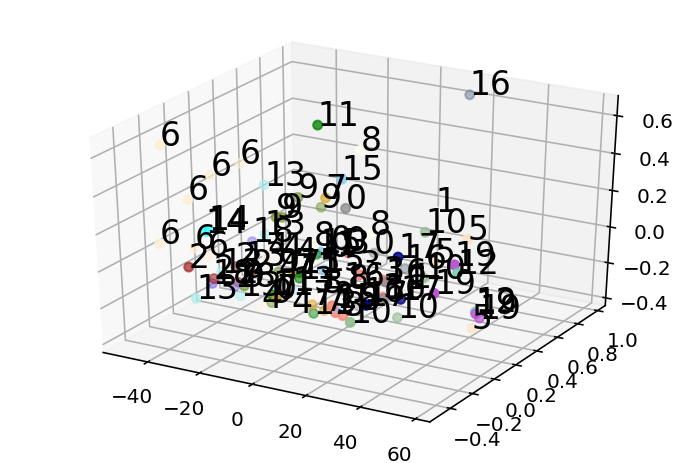

In [343]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()

### Cluster Analysis

In [344]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([18, 17,  9, 19,  0,  7, 13,  0,  6,  3,  8, 18, 16,  2, 13, 11,  9,
        4,  1,  5, 11,  0,  5, 18,  5, 15,  2,  1,  8, 10, 11,  9, 14, 19,
        8, 13,  5, 13, 11,  0,  1,  6, 12, 15, 10, 17, 16, 15, 14, 10,  9,
       19, 19,  2, 15,  3,  5, 10, 16,  3, 16,  9,  3, 17,  4, 16,  5,  8,
        1, 12, 10,  0, 16, 19,  1, 12,  5, 18,  0,  8, 17,  5,  4,  4,  5,
        5,  1, 11,  5,  4, 17, 15, 15, 14,  0,  4, 10,  3,  2,  3],
      dtype=int32)

In [345]:
dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.0510,0.314,139.915,18,Lil Uzi Vert,I Can Show You
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.298,0.0550,0.573,155.047,17,Lil Uzi Vert,Myron
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.344,0.1350,0.472,143.477,9,JACKBOYS,GATTI
3hR48Bj9Wgl6xunDG4nsRZ,0.806,0.809,0.159,0.1410,0.685,95.043,19,Kid Cudi,Leader Of The Delinquents
4lAQfuREAHG8IC0PiiigBt,0.862,0.650,0.355,0.0207,0.658,131.194,0,Lil Uzi Vert,Strawberry Peels (feat. Young Thug & Gunna)


In [333]:
#visualize the feature 
dfs.loc[dfs['cluster'] == 15]

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,title,artist
id,,,,,,,,,
6gWzuZHMKNtjLUsTPHCX10,0.855,0.676,0.3250,0.0888,0.509,133.082,15,Lo Mein,Lil Uzi Vert
0jBTxdEGB0YvKvZhf3AEIU,0.842,0.556,0.4420,0.1590,0.306,118.836,15,You Better Move,Lil Uzi Vert
2bQxqezLVNiJVeLO0RWPON,0.821,0.795,0.2500,0.1900,0.532,117.990,15,Lost & Found,YBN Cordae
4sWGHlZGM1XA7TyWdtBAbA,0.867,0.768,0.0791,0.1800,0.340,102.021,15,Moon Relate,Lil Uzi Vert
1Gz96Ab9xAEcaUTwaFx0ON,0.786,0.683,0.2050,0.1730,0.570,126.002,15,Prices,Lil Uzi Vert
3s2Qd1rsWqbvOoxpFTRp8D,0.689,0.701,0.2370,0.3140,0.370,94.982,15,Kraazy,Likybo
1raaNykBg1bDnWENUiglUA,0.730,0.729,0.0886,0.1670,0.467,113.012,15,Break My Heart,Dua Lipa
78QR3Wp35dqAhFEc2qAGjE,0.897,0.662,0.2920,0.0852,0.389,112.511,15,Drip Too Hard (Lil Baby & Gunna),Lil Baby
4jIb022gI284OzhbG16Q5L,0.769,0.831,0.3460,0.2610,0.583,108.025,15,DÃ©jÃ Vu (feat. Chaz French),Snakehips


In [320]:
#6 k-means assumed to cluster genres, but we are using k=20
dfs.groupby(['cluster']).count()

,danceability,energy,speechiness,acousticness,valence,tempo,title
cluster,,,,,,,
0,5,5,5,5,5,5,5
1,7,7,7,7,7,7,7
2,7,7,7,7,7,7,7
3,3,3,3,3,3,3,3
4,5,5,5,5,5,5,5
5,11,11,11,11,11,11,11
6,1,1,1,1,1,1,1
7,7,7,7,7,7,7,7
8,3,3,3,3,3,3,3


In [321]:
#create list of lists of song ids to put into recommendation function
i=0
list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while i<20:
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1
len(list_of_recs)

20

In [ ]:
j = 0
while j<20:
    if len(list_of_recs[j]) < 5:
        
    

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

In [23]:
#from sklearn_extra.cluster import KMedoids

#kmedoids = KMedoids(n_clusters=20, random_state=0)
#kmedoids.fit(dfs)
#kmedoids.cluster_centers_
#these are the coordinates of the 5 cluster medoids but not sure how to identify which 5 songs are represented by these points

## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [ ]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [ ]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [ ]:
create_playlist(sp, username, 'Pandas Party', 'A pure party playlist created by DJ Pandas!')

In [ ]:
# Find the new playlist's id
fetch_playlists(sp,username)

In [122]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 100])
        index += 100

In [123]:
list_track = df_party_exp_III.index

In [126]:
enrich_playlist(sp, username, '779Uv1K6LcYiiWxblSDjx7', list_track)

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/users/11153510588/playlists/779Uv1K6LcYiiWxblSDjx7/tracks:
 Insufficient client scope